In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import gc

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:transformers.file_utils:PyTorch version 1.11.0+cu113 available.
INFO:transformers.file_utils:TensorFlow version 2.8.2 available.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="roberta_train_empathy", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
#Load the tokenizer for the T5-base model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpaq1tkg2g


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
#Try out the tokenizer
text = "How are you feeling today?"
enc = tokenizer.encode_plus(text)
print(enc)

{'input_ids': [571, 33, 25, 1829, 469, 58], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
#See how the labels are encoded
labels = ["no", "weak", "strong"]
for lab in labels:
  print(tokenizer.encode(lab))

[150]
[5676]
[1101]


In [ ]:
class EmpathyDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "score"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = str(target) + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Empathy/roberta_train_empathy.txt"
test_path = "drive/MyDrive/Individual Project/Data/Empathy/test.txt"
val_path = "drive/MyDrive/Individual Project/Data/Empathy/val.txt"

In [ ]:
#load the tokenizer for this model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Empathy/', 'val', 512)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=16,
    gradient_accumulation_steps=2, 
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1',
    max_grad_norm=1.0,
    seed=21,
)

In [ ]:
args_dict.update({'data_dir': 'drive/MyDrive/Individual Project/Data/Empathy/', 'output_dir': '/content/', 'num_train_epochs':6})
args = argparse.Namespace(**args_dict)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
   filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /content/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmpathyDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
#create instance of model
model = T5FineTuner(args)

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpel7gm_5y


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id"

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#train loop
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.4314, device='cuda:0')

INFO:__main__:loss = tensor(0.1346, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1346, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4314, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.6984, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4686, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.2089, device='cuda:0')

INFO:__main__:train_loss = tensor(0.2089, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4686, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.1949, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.7133, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(0.1479, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1479, device='cuda:0')

INFO:__main__:val_loss = tensor(0.7133, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.1387, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.8704, device='cuda:0')

INFO:__main__:epoch = 2

INFO:__main__:loss = tensor(0.0435, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0435, device='cuda:0')

INFO:__main__:val_loss = tensor(0.8704, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.1000, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(1.0795, device='cuda:0')

INFO:__main__:epoch = 3

INFO:__main__:loss = tensor(0.0930, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0930, device='cuda:0')

INFO:__main__:val_loss = tensor(1.0795, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0683, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(1.1129, device='cuda:0')

INFO:__main__:epoch = 4

INFO:__main__:loss = tensor(0.0427, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0427, device='cuda:0')

INFO:__main__:val_loss = tensor(1.1129, device='cuda:0')



1

In [ ]:
torch.save(model.state_dict(), '/content/T5_student_RoBERTa_teacher.pt')

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Empathy', 'test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print some predictions
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual label: %s" % targets[i])
    print("predicted label: %s" % dec[i])
    print("=====================================================================\n")

text: Are there any major issues or fallouts with the people you are closest to right now?

Actual label: no
predicted label: no

text: I would like to know if there is anything happening right now in that feels bigger than
normal. Do you feel like you are facing a personal crisis?

Actual label: strong
predicted label: weak

text: How do you feel now?

Actual label: no
predicted label: no

text: Would you say that you have ever been able to really step outside of yourself and think of a
situation from a different point of view?

Actual label: weak
predicted label: weak

text: Do you see yourself as a saviour?

Actual label: no
predicted label: no

text: Thank you for being so open, I'm trying to determine the best way to help and know how hard it
is to revisit trauma. I would like to know if Protocol 6 proved too painful for you?

Actual label: strong
predicted label: strong

text: Thank you so much for opening up to me and telling me how you feel. I'm glad we could have
this chat and

In [ ]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/Individual Project/Data/Empathy', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in labels:
    print(i, 'detected invalid prediction')
    del outputs[i]
    del targets[i]

In [ ]:
#other metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     1.0000    0.7027    0.8254        37
      strong     0.8049    0.9429    0.8684        35
        weak     0.7045    0.7949    0.7470        39

    accuracy                         0.8108       111
   macro avg     0.8365    0.8135    0.8136       111
weighted avg     0.8347    0.8108    0.8114       111



In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = metrics.confusion_matrix(targets, outputs)

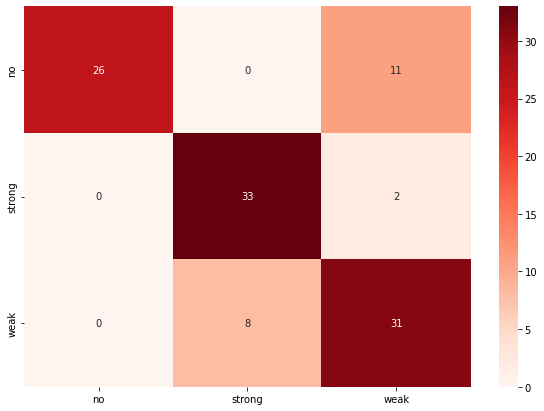

In [ ]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Reds', fmt='g')